In [7]:
################################################################################
# Split and save dataset
################################################################################

import os
import pandas as pd

df = pd.read_csv(os.getcwd() + '/data/population.csv', low_memory=False)

sample_size = 10000

sample_df = pd.concat([
    df[df['label'] == 'BenignTraffic'].sample(n=sample_size//2, random_state=42),
    df[df['label'] != 'BenignTraffic'].sample(n=sample_size//2, random_state=42)
    ])

print("Length of dataset: ", len(sample_df))
sample_df.to_csv(os.getcwd() + f'/data/sample-{sample_size}-2.csv', index=False)

Length of dataset before sampling:  10000


Text(0.5, 1.0, 'Record Count')

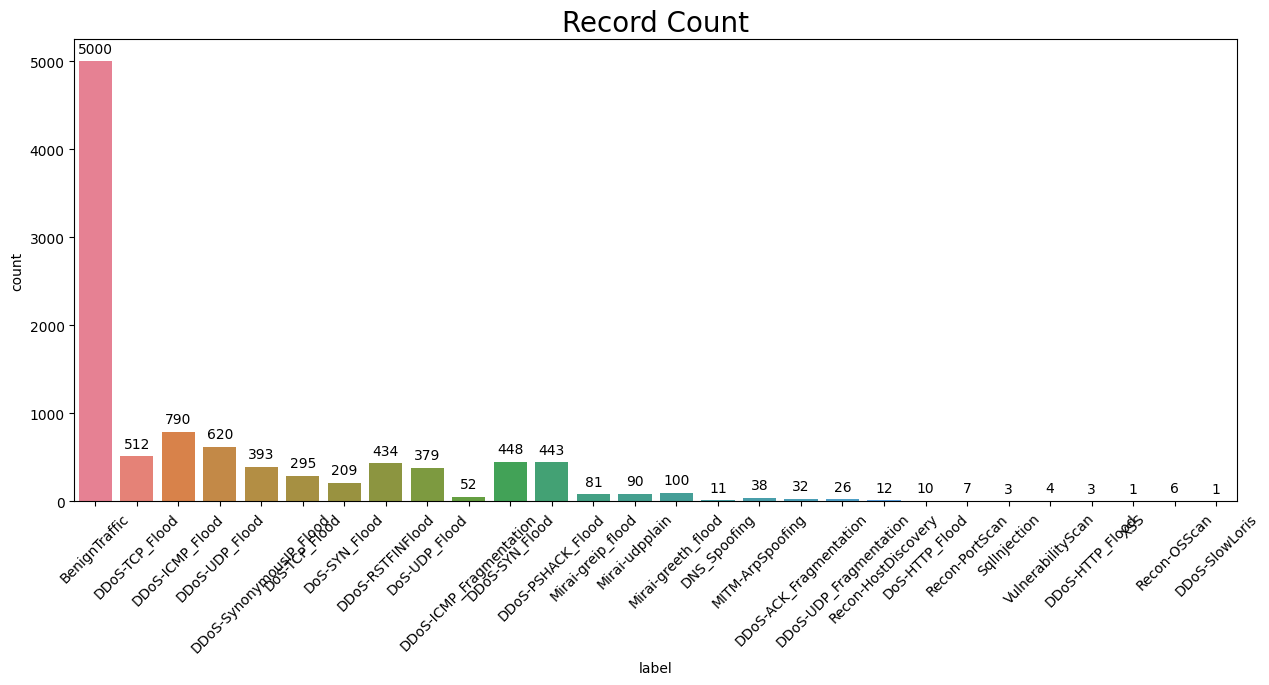

In [11]:
################################################################################
# Class distribution
################################################################################

import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

sample_size = 10000

saved_sample_df = pd.read_csv(os.getcwd() + f'/data/sample-{sample_size}-2.csv', low_memory=False)

plt.figure(figsize=(15, 6))
plt.xticks(rotation=45)
s = sns.countplot(data=saved_sample_df, x='label', hue='label')
for p in s.patches:
    s.annotate(format(p.get_height(), '.0f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 9), 
               textcoords = 'offset points')
plt.title('Record Count', fontsize=20)

# Evaluating Vector Store

In [1]:
################################################################################
# Load dataset and split it into training and test set
################################################################################

import pandas as pd
import os
from tabulate import tabulate

sample_size = 10000

# Load dateset
df = pd.read_csv(os.getcwd() + f'/data/sample-{sample_size}-2.csv')

# Split dataset according to attack type
normal_df = df[df['label'] == 'BenignTraffic']
attack_df = df[df['label'] != 'BenignTraffic']

# Drop columns
normal_df = normal_df.drop(columns=['label'])
attack_df = attack_df.drop(columns=['label'])

# Split dataset into training and test set
normal_df_train = normal_df.sample(frac=0.8, random_state=42)
normal_df_test = normal_df.drop(normal_df_train.index)
attack_df_train = attack_df.sample(frac=0.8, random_state=42)
attack_df_test = attack_df.drop(attack_df_train.index)

# Print dataset sizes in a table
data = [
    ["Normal", normal_df.shape[0], normal_df_train.shape[0], normal_df_test.shape[0]],
    ["Attack", attack_df.shape[0], attack_df_train.shape[0], attack_df_test.shape[0]]
]
print(tabulate(data, headers=["Atack type", "Total", "Train", "Test"], tablefmt="grid"))

+--------------+---------+---------+--------+
| Atack type   |   Total |   Train |   Test |
+==============+=========+=========+========+
| Normal       |    5000 |    4000 |   1000 |
+--------------+---------+---------+--------+
| Attack       |    5000 |    4000 |   1000 |
+--------------+---------+---------+--------+


In [6]:
################################################################################
# Add documents to vector store
################################################################################

from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from tqdm import tqdm

# Initialize embeddings
embeddings = HuggingFaceEmbeddings()

# Initialize vector store
vector_store = Chroma(
    collection_name="cic-iot",
    embedding_function=embeddings, 
    persist_directory=f"./vector-stores/chroma-db-{sample_size}-2")

# Add batched documents to vector store
batch_size = 16
total_normal_documents = normal_df_train.shape[0]
total_attack_documents = attack_df_train.shape[0]

for i in tqdm(range(0, total_normal_documents, batch_size), ncols=100, desc="Adding normal documents to vector store"):
    documents = [Document(page_content=str(normal_df_train.iloc[i+j].to_list()), metadata={"source": "cic-iot", "label": "normal"}) for j in range(min(batch_size, total_normal_documents-i))]
    vector_store.add_documents(documents)

for i in tqdm(range(0, total_attack_documents, batch_size), ncols=100, desc="Adding attack documents to vector store"):
    documents = [Document(page_content=str(attack_df_train.iloc[i+j].to_list()), metadata={"source": "cic-iot", "label": "attack"}) for j in range(min(batch_size, total_attack_documents-i))]
    vector_store.add_documents(documents)

print(f"Total number of documents added: {total_attack_documents+total_normal_documents}")

/opt/home/s4025371/anaconda3/envs/llm/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Adding attack documents to vector store: 100%|██████████████████| 250/250 [1:05:31<00:00, 15.73s/it]

Total number of documents added: 8000


In [3]:
################################################################################
# Predict from Vector Store
################################################################################

from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from statistics import mode
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

train_set_size = 1000#sample_size

embeddings = HuggingFaceEmbeddings()

vector_store = Chroma(
    collection_name="cic-iot",
    embedding_function=embeddings, 
    persist_directory=f"./vector-stores/chroma-db-{train_set_size}-2")

retriever = vector_store.as_retriever(
    search_type="mmr", 
    search_kwargs={"k": 5, "fetch_k": 5})

datasets = {"normal": normal_df_test, "attack": attack_df_test}
y_pred = []
y_true = []
for attack_type, dataset in datasets.items():
    test_set_size = dataset.shape[0]
    for i in tqdm(range(test_set_size), ncols=100, desc=f"Predicting {attack_type} entries..."):
        query_document = str(dataset.iloc[i].to_list())
        similar_documents = retriever.invoke(query_document, filter={"source": "cic-iot"})
        y_true.append(attack_type)
        y_pred.append(mode([doc.metadata["label"] for doc in similar_documents]))

c_report = classification_report(y_true, y_pred)
c_matrix = confusion_matrix(y_true, y_pred)

with open(f"results/result-{sample_size}-2-{train_set_size}.txt", "w") as f:
    f.write(f"Classication Report\n{c_report}\n\nConfusion Matrix\n{c_matrix}")

print(c_report)
print(c_matrix)

/opt/home/s4025371/anaconda3/envs/llm/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Predicting attack entries...: 100%|█████████████████████████████| 1000/1000 [04:57<00:00,  3.37it/s]

              precision    recall  f1-score   support

      attack       0.99      0.99      0.99      1000
      normal       0.99      0.98      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

[[988  12]
 [ 15 985]]


# Evaluating ML Models

In [1]:
################################################################################
# Load dataset and split it into training and test set
################################################################################

import pandas as pd
import os
from tabulate import tabulate

sample_size = 10000

# Load dateset
df = pd.read_csv(os.getcwd() + f'/data/sample-{sample_size}-2.csv')

# Split dataset according to attack type
normal_df = df[df['label'] == 'BenignTraffic']
attack_df = df[df['label'] != 'BenignTraffic']
normal_df.loc[:, 'label'] = 'normal'
attack_df.loc[:, 'label'] = 'attack'

# Split dataset into training and test set
normal_df_train = normal_df.sample(frac=0.8, random_state=42)
normal_df_test = normal_df.drop(normal_df_train.index)
attack_df_train = attack_df.sample(frac=0.8, random_state=42)
attack_df_test = attack_df.drop(attack_df_train.index)

X_train = pd.concat([normal_df_train, attack_df_train]).drop(columns=['label'])
y_train = pd.concat([normal_df_train, attack_df_train])['label']
X_test = pd.concat([normal_df_test, attack_df_test]).drop(columns=['label'])
y_test = pd.concat([normal_df_test, attack_df_test])['label']

print("Training set size: ", X_train.shape[0])
print("Test set size: ", X_test.shape[0])
print(X_train.columns)

Training set size:  8000
Test set size:  2000
Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'SSH',
       'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius',
       'Covariance', 'Variance', 'Weight'],
      dtype='object')


In [6]:
################################################################################
# Predict from Decision Tree model
################################################################################

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create an instance of the DecisionTreeClassifier model
model = DecisionTreeClassifier()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the labels for the test data
y_true = y_test
y_pred = model.predict(X_test)

# Evaluate the model
# c_report = classification_report(y_true, y_pred)
# c_matrix = confusion_matrix(y_true, y_pred)

# with open(f"results/result-dt-{sample_size}-2.txt", "w") as f:
#     f.write(f"Classication Report\n{c_report}\n\nConfusion Matrix\n{c_matrix}")

# print(c_report)
# print(c_matrix)

# Feature importance
feature_names = list(X_train.columns)
feature_importance = model.feature_importances_
feature_importance, feature_names = zip(*sorted(zip(feature_importance, feature_names), reverse=True))
print("Feature importance:")
for i, (importance, name) in enumerate(zip(feature_importance, feature_names)):
    print(f"{i+1}. {name}: {importance}")

(0.9262515183029744, 0.01950204897567687, 0.014682856076260246, 0.009987209580889507, 0.0049846663521287676, 0.003650406462218627, 0.002416410375688557, 0.002303498738134299, 0.00217152711179197, 0.0020020561106840395, 0.0019015619457918597, 0.001738382420715361, 0.0016505816313026112, 0.0015111134728448244, 0.001505555555555556, 0.001158088235294118, 0.0008780885488523777, 0.0004891304347826084, 0.0004553510311206204, 0.0003333333333333334, 0.00025000000000000006, 0.00015151515151515124, 2.510015244442321e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)


In [ ]:
################################################################################
# Feature Importance - Decision Tree 
################################################################################

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

n = 10

for i in range(n):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    model.
    y_true = y_test
    y_pred = model.predict(X_test)


In [22]:
################################################################################
# Predict from Random Forest model
################################################################################

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create an instance of the DecisionTreeClassifier model
model = RandomForestClassifier()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the labels for the test data
y_true = y_test
y_pred = model.predict(X_test)

# Evaluate the model
# c_report = classification_report(y_true, y_pred)
# c_matrix = confusion_matrix(y_true, y_pred)

# with open(f"results/result-rf-{sample_size}-2.txt", "w") as f:
#     f.write(f"Classication Report\n{c_report}\n\nConfusion Matrix\n{c_matrix}")

# print(c_report)
# print(c_matrix)

# Feature importance
feature_names = list(X_train.columns)
feature_importance = model.feature_importances_
feature_importance, feature_names = zip(*sorted(zip(feature_importance, feature_names), reverse=True))
print("Feature importance:")
for i, (importance, name) in enumerate(zip(feature_importance, feature_names)):
    print(f"{i+1}. {name}: {importance}")
# print("\n".join([f"{feature_names[i]} - {feature_importance[i]}" for i in range(len(feature_importance))]))

Feature importance:
1. rst_count: 0.1704485525841988
2. Variance: 0.12310362374488552
3. urg_count: 0.11224615846590319
4. Magnitue: 0.09054201226852497
5. Tot size: 0.07531699305752129
6. AVG: 0.07185781185226732
7. Radius: 0.04035432822297477
8. Std: 0.03832583430905882
9. Max: 0.03659628601971633
10. Covariance: 0.032604414871005696
11. Header_Length: 0.03240954406743106
12. Tot sum: 0.030374984902641403
13. ack_flag_number: 0.02591538559409568
14. flow_duration: 0.024855556287278223
15. Min: 0.015301753311052957
16. IAT: 0.014811653417317371
17. Duration: 0.014380784152727736
18. Protocol Type: 0.012980713010499164
19. HTTPS: 0.007804927883519462
20. Weight: 0.006219293708219519
21. Srate: 0.004850551045704954
22. Number: 0.00411474535451239
23. Rate: 0.0030387758613368504
24. syn_count: 0.002451121533606566
25. fin_count: 0.0017387379809941886
26. ack_count: 0.001427891069416823
27. psh_flag_number: 0.001321411982344442
28. syn_flag_number: 0.0011404254823945393
29. LLC: 0.0008919

In [ ]:
################################################################################
# Predict from Logistic Regression model
################################################################################

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Create an instance of the DecisionTreeClassifier model
model = LogisticRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the labels for the test data
y_true = y_test
y_pred = model.predict(X_test)

# Evaluate the model
c_report = classification_report(y_true, y_pred)
c_matrix = confusion_matrix(y_true, y_pred)

with open(f"results/result-lr-{sample_size}-2.txt", "w") as f:
    f.write(f"Classication Report\n{c_report}\n\nConfusion Matrix\n{c_matrix}")

print(c_report)
print(c_matrix)

In [ ]:
################################################################################
# Predict from SVM model
################################################################################

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Create an instance of the DecisionTreeClassifier model
model = SVC()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the labels for the test data
y_true = y_test
y_pred = model.predict(X_test)

# Evaluate the model
c_report = classification_report(y_true, y_pred)
c_matrix = confusion_matrix(y_true, y_pred)

with open(f"results/result-svm-{sample_size}-2.txt", "w") as f:
    f.write(f"Classication Report\n{c_report}\n\nConfusion Matrix\n{c_matrix}")

print(c_report)
print(c_matrix)